#Classifying Flu Vaccine and H1N1 Vaccine
##Final Project in CISC 451/839

In [ ]:
#load dataset in from google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
#from sklearnex import patch_sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


#Reading in data
#data = pd.read_csv('/content/h1n1_flu.csv')
data = pd.read_csv('/content/drive/MyDrive/CISC451_DATASETS/h1n1_flu.csv')

In [ ]:
#Declaring targets
targets = ['VACC_H1N1_F', 'VACC_SEAS_F']

In [ ]:
#Dropping records where both targets have NaN
data = data.dropna(axis = 0, subset = targets, how = 'any')
print(data.shape)

(70258, 172)


In [ ]:
#Dropping columns based on coverage
missing_val_threshold = 0.75  # 75% of data must be present in the feature for us to keep it 
missing_series = data.isnull().sum()/data.shape[0]  # count the number of nans in proportion to the total number of records
record_missing = pd.DataFrame(missing_series[missing_series > missing_val_threshold]).reset_index().rename(columns = {'index':'feature',0:'missing_val_fraction'})  # identify columns with more NaNs than the threshold
missing_val_drop = list(record_missing['feature']) 
df_cleaned_1 = data.copy()
df_cleaned_1 = df_cleaned_1.loc[:, ~df_cleaned_1.columns.isin(missing_val_drop)]  # delete the columns
print(len(missing_val_drop))
print(missing_val_drop)
print(df_cleaned_1.shape)

30
['VACC1_H1N1_M', 'VACC1_H1N1_T', 'VACC1_H1N1_Y', 'VACC2_H1N1_M', 'VACC2_H1N1_T', 'VACC2_H1N1_Y', 'VACC2_SEAS_M', 'VACC2_SEAS_T', 'VACC2_SEAS_Y', 'PLACE_H1N1_CLIN_F', 'PLACE_H1N1_DEPT_F', 'PLACE_H1N1_DKNW_F', 'PLACE_H1N1_DOCT_F', 'PLACE_H1N1_HOSP_F', 'PLACE_H1N1_MTRY_F', 'PLACE_H1N1_OTHM_F', 'PLACE_H1N1_OTHN_F', 'PLACE_H1N1_PHRM_F', 'PLACE_H1N1_REFD_F', 'PLACE_H1N1_SCHL_F', 'PLACE_H1N1_SCTR_F', 'PLACE_H1N1_SMKT_F', 'PLACE_H1N1_WORK_F', 'ILI_DIAG_H1N1_F', 'ILI_DIAG_SEAS_F', 'ILI_TIME_OFF', 'ILI_TREAT_F', 'PSL_1', 'PSL_2', 'C_INSURE2']
(70258, 142)


#Converting incorrect floats to ints


In [ ]:
#Dropping this column because it is unary
df_cleaned_1.drop(['MSA_DEF'], axis = 1, inplace=True) #DROP COMPLETELY, because unary

In [ ]:
#Casting all floats as int except "FLUWT", which needs to be a float
float64list = list(df_cleaned_1.loc[:, df_cleaned_1.dtypes == np.float64].columns) 
for x in float64list:
    df_cleaned_1[x] = np.floor(pd.to_numeric(df_cleaned_1[x], errors='coerce')).astype('Int64')
df_cleaned_1['FLUWT'] = df_cleaned_1['FLUWT'].astype('float64') 
df_cleaned_1.dtypes

Unnamed: 0      int64
INT_MONTH      object
LANGUAGE        int64
SAMP_DESIG     object
SEQNUMHH        int64
               ...   
CEN_REG         int64
FLUWT         float64
HHS_REGION      int64
MSA3_I          int64
STATE           int64
Length: 141, dtype: object

#Convert objects (label encoding)

In [ ]:
#Ssolating the object within the dataset
obj = ['SAMP_DESIG', 'SUBGROUP','INT_MONTH']
df_cleaned_1[obj] = df_cleaned_1[obj].astype('category')

In [ ]:
#Label encoding the converted object ones
df_cleaned_1['INT_MONTH'] = df_cleaned_1['INT_MONTH'].cat.codes
df_cleaned_1['SAMP_DESIG'] = df_cleaned_1['SAMP_DESIG'].cat.codes
df_cleaned_1['SUBGROUP'] = df_cleaned_1['SUBGROUP'].cat.codes

#PCA & KNN

In [ ]:
#Some more imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Read in KNN results 

In [ ]:
knn = pd.read_csv('/content/drive/MyDrive/CISC451_DATASETS/imputed_data_h1n1_seas.csv') #KNN performed separately on high compute cluster
#knn = pd.read_csv('/content/imputed_data_h1n1_seas.csv')

In [ ]:
#Drop first column of dataframe
knn = knn.iloc[: , 1:]

In [ ]:
#Remove the targets
knn_no_targets = knn.copy()
knn_no_targets.drop(['VACC_H1N1_F', 'VACC_SEAS_F'], axis = 1, inplace=True)

In [ ]:
#Check correlation and drop columns
cor_matrix = knn_no_targets.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(len(to_drop))
print(to_drop)
knn_no_targets.drop(to_drop, axis = 1, inplace=True)

6
['SEQNUMP', 'VACC1_SEAS_Y', 'VACC_PNEU_F', 'KNOW_H1N1_LITL_F', 'N_PEOPLE_R', 'RACEETH4_I']


In [ ]:
#Run PCA for feature reduction
pca = PCA(n_components=2)
pca.fit(knn_no_targets)

PCA(n_components=2)

In [ ]:
#Sorting based on highest importance
pcaRes =pd.DataFrame(pca.components_,columns=knn_no_targets.columns,index = ['PC-1','PC-2']).sort_values(by=['PC-1'], axis=1, ascending=False)

pc1 = pcaRes.loc[["PC-1"]]
pc1.head()

SEQNUMHH  RENT_OWN_R    INSURE    Q9_NUM       Q95  INT_MONTH  INC_CAT1  \
PC-1       1.0    0.000007  0.000003  0.000003  0.000002   0.000001  0.000001   

            AGEGRP         Q24_B        MSA3_I  ...  VACC1_SEAS_M        Q9  \
PC-1  6.753735e-07  5.595527e-07  2.910073e-07  ... -8.841159e-07 -0.000002   

           Q24  Q95_INDSTR    HQ24_B     STATE      HQ23      HQ24  Q95_OCCPN  \
PC-1 -0.000003   -0.000003 -0.000003 -0.000004 -0.000009 -0.000011  -0.000011   

         FLUWT  
PC-1 -0.000949  

[1 rows x 132 columns]

[Text(0, 0, 'RENT_OWN_R'),
 Text(0, 0, 'INSURE'),
 Text(0, 0, 'Q9_NUM'),
 Text(0, 0, 'Q95'),
 Text(0, 0, 'INT_MONTH'),
 Text(0, 0, 'INC_CAT1'),
 Text(0, 0, 'AGEGRP'),
 Text(0, 0, 'Q24_B'),
 Text(0, 0, 'MSA3_I'),
 Text(0, 0, 'CEN_REG'),
 Text(0, 0, 'HHS_REGION'),
 Text(0, 0, 'INT_H1N1_PYES_F'),
 Text(0, 0, 'INT_NEXT_PNOT_F'),
 Text(0, 0, 'EDUCATION_COMP'),
 Text(0, 0, 'DOCREC_NTHR_F'),
 Text(0, 0, 'INT_SEAS_DYES_F'),
 Text(0, 0, 'B_H1N1_AVOID'),
 Text(0, 0, 'PLACE_SEAS_WORK_F'),
 Text(0, 0, 'PLACE_SEAS_OTHN_F'),
 Text(0, 0, 'B_H1N1_RCONT')]

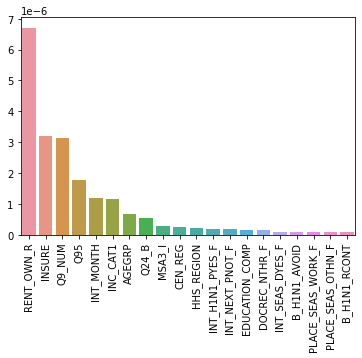

In [ ]:
#Ploting the top 21 attibutes
import seaborn as sns
ax = sns.barplot(data=pc1[pc1.columns[1:21]])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

#Basic Random Forest Models
##First model is the H1N1

In [ ]:
#Declaring the labels
Y_H1N1 = knn['VACC_H1N1_F']
Y_FLU = knn['VACC_SEAS_F']

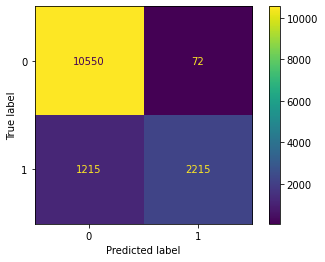

Classification report for model 1 : 
               precision    recall  f1-score   support

           1       0.97      0.65      0.77      3430
           0       0.90      0.99      0.94     10622

    accuracy                           0.91     14052
   macro avg       0.93      0.82      0.86     14052
weighted avg       0.91      0.91      0.90     14052



In [ ]:
#H1N1 model 

X1train, X1test, y1train, y1test = train_test_split(knn_no_targets[pc1[pc1.columns[0:21]].columns], Y_H1N1.astype("int"), test_size=0.2)
model1 = RandomForestClassifier(n_jobs=4)
model1.fit(X1train, y1train)
y1pred = model1.predict(X1test)
cm1 = confusion_matrix(y1test, y1pred, labels=model1.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=model1.classes_)
disp1.plot()
plt.show()
matrix1 = classification_report(y1test,y1pred,labels=[1,0])
print('Classification report for model 1 : \n',matrix1)

In [ ]:
#Printing the most important attributes
importances1 = list(zip(model1.feature_importances_, pc1.columns))
importances1.sort(reverse=True)
print(importances1[:133])

[(0.410793508785504, 'INT_H1N1_PYES_F'), (0.0761729084174719, 'INT_MONTH'), (0.06991583259374938, 'SEQNUMHH'), (0.04828541534859149, 'Q9_NUM'), (0.04236205340710164, 'DOCREC_NTHR_F'), (0.03589157773298764, 'INC_CAT1'), (0.035139328434556055, 'HHS_REGION'), (0.033013346325477304, 'AGEGRP'), (0.02778954150450452, 'Q24_B'), (0.027030748079608667, 'EDUCATION_COMP'), (0.024886591877845844, 'INT_NEXT_PNOT_F'), (0.023433680643433298, 'PLACE_SEAS_WORK_F'), (0.021329621500617405, 'Q95'), (0.019148039220758233, 'MSA3_I'), (0.017985399106360166, 'CEN_REG'), (0.01762958405202327, 'INT_SEAS_DYES_F'), (0.0160979414069617, 'INSURE'), (0.01522580577721646, 'B_H1N1_RCONT'), (0.014203025059536767, 'B_H1N1_AVOID'), (0.012369315709714258, 'RENT_OWN_R'), (0.011296735015979963, 'PLACE_SEAS_OTHN_F')]


##Flu model

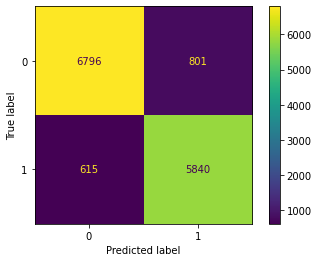

Classification report for model 1 : 
               precision    recall  f1-score   support

           1       0.88      0.90      0.89      6455
           0       0.92      0.89      0.91      7597

    accuracy                           0.90     14052
   macro avg       0.90      0.90      0.90     14052
weighted avg       0.90      0.90      0.90     14052



In [ ]:
#FLU model

X2train, X2test, y2train, y2test = train_test_split(knn_no_targets[pc1[pc1.columns[0:21]].columns], Y_FLU.astype("int"), test_size=0.2)
model2 = RandomForestClassifier(n_jobs=4)
model2.fit(X2train, y2train)
y2pred = model2.predict(X2test)
cm2 = confusion_matrix(y2test, y2pred, labels=model2.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=model2.classes_)
disp2.plot()
plt.show()
matrix2 = classification_report(y2test,y2pred,labels=[1,0])
print('Classification report for model 1 : \n',matrix2)

In [ ]:
#Printing important features
importances2 = list(zip(model2.feature_importances_, pc1.columns))
importances2.sort(reverse=True)
print(importances2[:10])

[(0.2406891845816015, 'PLACE_SEAS_WORK_F'), (0.13778339763305952, 'INT_SEAS_DYES_F'), (0.0932937247143566, 'PLACE_SEAS_OTHN_F'), (0.07977465488436876, 'DOCREC_NTHR_F'), (0.05209883215691592, 'SEQNUMHH'), (0.04567543145416944, 'AGEGRP'), (0.039717768811586104, 'INT_NEXT_PNOT_F'), (0.03901489423769043, 'Q9_NUM'), (0.0365884501011702, 'INT_H1N1_PYES_F'), (0.03116638005140253, 'INT_MONTH')]


#Boosted Random Trees 
##Flu and H1N1

In [ ]:
#Some more imports
from xgboost.sklearn import XGBRFClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import xgboost as xgb

In [ ]:
#Flu model
X3train, X3test, y3train, y3test = train_test_split(knn_no_targets[pc1[pc1.columns[0:21]].columns], Y_FLU.astype("int"), test_size=0.2)

model3 = XGBRFClassifier(n_estimators=100)
model3.fit(X3train, y3train)

y3pred = model3.predict(X3test)


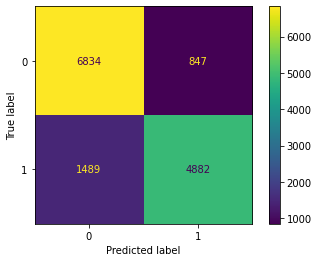

Classification report for model 1 : 
               precision    recall  f1-score   support

           1       0.85      0.77      0.81      6371
           0       0.82      0.89      0.85      7681

    accuracy                           0.83     14052
   macro avg       0.84      0.83      0.83     14052
weighted avg       0.84      0.83      0.83     14052



In [ ]:
cm3 = confusion_matrix(y3test, y3pred, labels=[0, 1])
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=[0, 1])
disp3.plot()
plt.show()
matrix3 = classification_report(y3test, y3pred,labels=[1,0])
print('Classification report for model 1 : \n',matrix3)

##H1N1 Boosted Trees

In [ ]:
#H1N1 Model
X4train, X4test, y4train, y4test = train_test_split(knn_no_targets[pc1[pc1.columns[0:21]].columns], Y_H1N1.astype("int"), test_size=0.2)

model4 = XGBRFClassifier(n_estimators=100)
model4.fit(X4train, y4train)

y4pred = model4.predict(X4test)

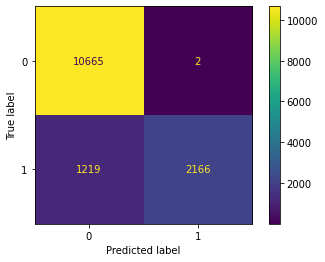

Classification report for model 1 : 
               precision    recall  f1-score   support

           1       1.00      0.64      0.78      3385
           0       0.90      1.00      0.95     10667

    accuracy                           0.91     14052
   macro avg       0.95      0.82      0.86     14052
weighted avg       0.92      0.91      0.91     14052



In [ ]:
cm4 = confusion_matrix(y4test, y4pred, labels=[0, 1])
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4,display_labels=[0, 1])
disp4.plot()
plt.show()
matrix4 = classification_report(y4test, y4pred,labels=[1,0])
print('Classification report for model 1 : \n',matrix4)